In [1]:
#Using APRBS with a 90 degree peak to peak

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import math
from simulation_tools import PRBS
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle as pkl

Using TensorFlow backend.


In [3]:
df = pd.read_csv('aprbs_90ptp_log.txt')
df = df.drop(['timestamp'], axis=1)
#Centre positions at 0
df[['rot_command', 'flex_command', 'rot_cur_pos', 
    'flex_cur_pos','rot_next_pos', 'flex_next_pos']] = df[['rot_command', 'flex_command', 
                                                           'rot_cur_pos', 'flex_cur_pos', 
                                                           'rot_next_pos', 'flex_next_pos']] - 2048

#Centre velocities at 0
df[['rot_cur_vel', 'flex_cur_vel', 
    'rot_next_vel', 'flex_next_vel']] = df[['rot_cur_vel', 'flex_cur_vel', 'rot_next_vel', 'flex_next_vel']] - 1024
#Convert to radians
df = df * 2 * math.pi/4096
df.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_next_pos,flex_next_pos,rot_cur_vel,flex_cur_vel,rot_next_vel,flex_next_vel
0,-3.141593,-3.141593,-0.003068,-0.015340,-0.003068,-0.015340,-1.570796,-1.570796,-1.570796,-1.570796
1,-0.622796,-0.622796,-0.003068,-0.015340,-0.003068,-0.015340,-1.570796,-1.570796,-1.570796,-1.570796
2,-0.622796,-0.622796,-0.003068,-0.015340,-0.012272,-0.023010,-1.570796,-1.570796,0.061359,0.061359
3,-0.622796,-0.622796,-0.012272,-0.023010,-0.030680,-0.039884,0.061359,0.061359,0.141126,0.134990
4,-0.622796,-0.622796,-0.030680,-0.039884,-0.055223,-0.062893,0.141126,0.134990,0.239301,0.227029


In [4]:
X = df[['rot_command', 'flex_command', 'rot_cur_pos', 'flex_cur_pos', 'rot_cur_vel', 'flex_cur_vel']]
y = df[['rot_next_pos', 'flex_next_pos', 'rot_next_vel', 'flex_next_vel']]

In [5]:
X.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_cur_vel,flex_cur_vel
0,-3.141593,-3.141593,-0.003068,-0.015340,-1.570796,-1.570796
1,-0.622796,-0.622796,-0.003068,-0.015340,-1.570796,-1.570796
2,-0.622796,-0.622796,-0.003068,-0.015340,-1.570796,-1.570796
3,-0.622796,-0.622796,-0.012272,-0.023010,0.061359,0.061359
4,-0.622796,-0.622796,-0.030680,-0.039884,0.141126,0.134990


In [6]:
y.head()

,rot_next_pos,flex_next_pos,rot_next_vel,flex_next_vel
0,-0.003068,-0.015340,-1.570796,-1.570796
1,-0.003068,-0.015340,-1.570796,-1.570796
2,-0.012272,-0.023010,0.061359,0.061359
3,-0.030680,-0.039884,0.141126,0.134990
4,-0.055223,-0.062893,0.239301,0.227029


In [7]:
X_train = X[:8000]
X_test = X[8000:].reset_index(drop=True)
y_train = y[:8000]
y_test = y[8000:].reset_index(drop=True)

# LSTM

In [8]:
seq_len_train = 100
num_inputs = 1
num_outputs = 1
lstm = Sequential()
lstm.add(LSTM(16, batch_input_shape=(1, None, num_inputs), return_sequences=True, stateful=True))
lstm.add(Dense(num_outputs))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
lstm.compile(opt, loss='mse')
lstm.summary()

W0809 10:12:22.002001  9556 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 10:12:22.017991  9556 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 10:12:22.019953  9556 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 10:12:22.197516  9556 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, None, 16)             1152      
_________________________________________________________________
dense_1 (Dense)              (1, None, 1)              17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [9]:
def run_lstm(seq_len, X, y=None):
    outputs = []


    batches = len(X)//seq_len

    mse = 0
    for i in range(batches):
        lstm_input = np.array(X[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, num_inputs)
        model_output = lstm.predict(lstm_input, batch_size=1)

        if y is not None:
            lstm_labels = np.array(y[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, num_outputs)
            mse += mean_squared_error(lstm_labels[0], model_output[0])
        outputs.extend(model_output[0][:])

    if y is not None:
        mse /= batches
        print("MSE:",mse)
    return outputs
    

In [10]:
X_train_lstm = X_train[['rot_command']]
y_train_lstm = y_train[['rot_next_pos']]
X_test_lstm = X_test[['rot_command']]
y_test_lstm = y_test[['rot_next_pos']]

In [11]:
batches = len(X_train_lstm)//seq_len_train
epochs = 100

In [12]:
for _ in range(epochs):
    err = 0
    for i in range(batches):
        lstm_input = np.array(X_train_lstm[i*seq_len_train:(i+1)*seq_len_train]).reshape(1, seq_len_train, num_inputs)
        lstm_labels = np.array(y_train_lstm[i*seq_len_train:(i+1)*seq_len_train]).reshape(1, seq_len_train, num_outputs)
        hist = lstm.fit(lstm_input, lstm_labels, batch_size=1, verbose=0)
        err += hist.history['loss'][0]
    err /= batches
    print(err, ',', end='')

W0809 10:12:22.368068  9556 deprecation.py:323] From c:\users\james\envs\slw_env\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0809 10:12:22.667798  9556 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0809 10:12:22.731627  9556 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



0.032663263851804916 ,0.011090688761896672 ,0.008943659868600662 ,0.008379429956403329 ,0.007634160790894384 ,0.007020645831175898 ,0.006513649796852405 ,0.006105116123580956 ,0.005791185035741364 ,0.005563415256983717 ,0.0054062820237049895 ,0.005300520256014352 ,0.0052284172146926265 ,0.005176846927408008 ,0.005137281808151784 ,0.005104458889627494 ,0.00507507694837841 ,0.005046951488566265 ,0.005018497289711377 ,0.004988494354529393 ,0.004955968744252459 ,0.004920141371258069 ,0.004880377193967433 ,0.0048361506952460335 ,0.004787004800982686 ,0.004732478649475525 ,0.004672147865767329 ,0.0046054397538682675 ,0.0045317450687434755 ,0.004450304162219254 ,0.004360221804108733 ,0.004260503930072446 ,0.004150172539493724 ,0.0040278471102055844 ,0.0038953558925641117 ,0.0037559033136410846 ,0.003616588773989804 ,0.003485338788414083 ,0.0033657571803360044 ,0.0032583315885631237 ,0.0031632330668799114 ,0.0030801145650912075 ,0.003008521796709829 ,0.0029476663315790574 ,0.002896239806659650

### Testing on test set

MSE: 0.0018179185014205674


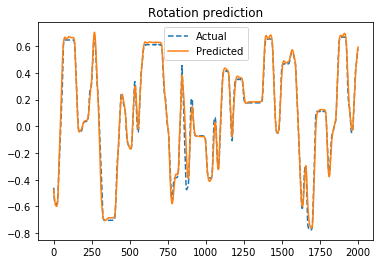

In [13]:
rot_position = run_lstm(1, X_test_lstm, y_test_lstm)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_position)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

### Testing on a step input

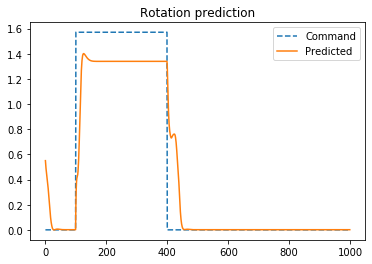

In [14]:
#Generalization to 90 is not so good
step = np.zeros((1000, num_inputs))
step[100:400, 0] = math.pi/2
# step[500:800, 1] = math.pi/2

rot_position = run_lstm(1, step)

plt.plot(step, '--')
plt.plot(rot_position)
plt.legend(['Command', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

In [15]:
# pkl.dump(lstm, open('lstm_model.pkl', 'wb'))

# Neural Network

In [16]:
nn = Sequential()
nn.add(Dense(8, input_shape=(6,), activation='relu'))
nn.add(Dense(4))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
nn.compile(opt, loss='mse')
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [17]:
nn.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
8000/8000 [==============================] - 0s 40us/step - loss: 0.9077
Epoch 2/100
8000/8000 [==============================] - 0s 18us/step - loss: 0.1701
Epoch 3/100
8000/8000 [==============================] - 0s 19us/step - loss: 0.0459
Epoch 4/100
8000/8000 [==============================] - 0s 20us/step - loss: 0.0300
Epoch 5/100
8000/8000 [==============================] - 0s 25us/step - loss: 0.0264
Epoch 6/100
8000/8000 [==============================] - 0s 22us/step - loss: 0.0254
Epoch 7/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0248
Epoch 8/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0244
Epoch 9/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0239
Epoch 10/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0235
Epoch 11/100
8000/8000 [==============================] - 0s 21us/step - loss: 0.0233
Epoch 12/100
8000/8000 [==============================] - 0s 20

### Testing on test set

MSE: 0.29940692752741305


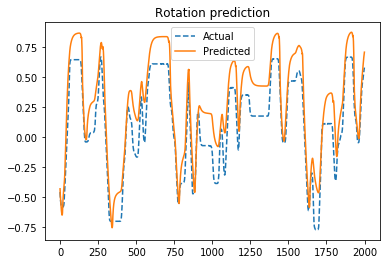

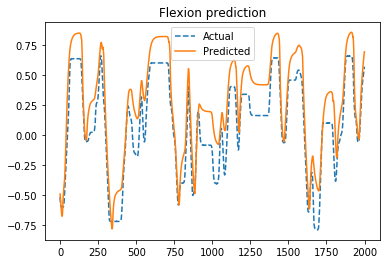

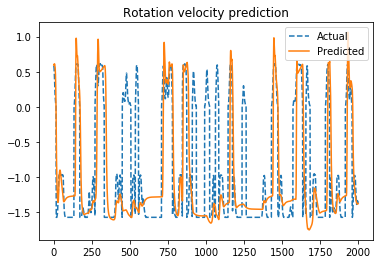

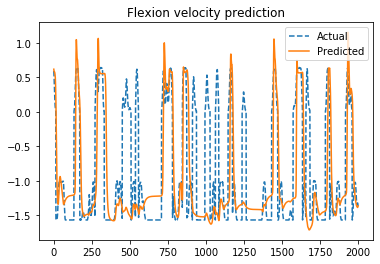

In [18]:
rot_positions = np.zeros(len(X_test))
flex_positions = np.zeros(len(X_test))
rot_velocities = np.zeros(len(X_test))
flex_velocities = np.zeros(len(X_test))

rot_cur_pos = X_test['rot_cur_pos'].iloc[0]
flex_cur_pos = X_test['flex_cur_pos'].iloc[0]
rot_cur_vel = X_test['rot_cur_vel'].iloc[0]
flex_cur_vel = X_test['flex_cur_vel'].iloc[0]
mse = 0
for i in range(len(X_test)):
    rot_positions[i] = rot_cur_pos
    flex_positions[i] = flex_cur_pos
    rot_velocities[i] = rot_cur_vel
    flex_velocities[i] = flex_cur_vel

    rot_command = X_test['rot_command'].iloc[i]
    flex_command = X_test['flex_command'].iloc[i]

    model_input = np.array([[rot_command, flex_command, rot_cur_pos, flex_cur_pos, rot_cur_vel, flex_cur_vel]])
    model_output = nn.predict(model_input, batch_size=1)[0]
    rot_cur_pos = model_output[0]
    flex_cur_pos = model_output[1]
    rot_cur_vel = model_output[2]
    flex_cur_vel = model_output[3]
    
    mse += mean_squared_error(y_test.iloc[i], model_output)
mse /= len(X_test)
print("MSE:",mse)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

plt.plot(y_test['rot_next_vel'], '--')
plt.plot(rot_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation velocity prediction")
plt.show()

plt.plot(y_test['flex_next_vel'], '--')
plt.plot(flex_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion velocity prediction")
plt.show()
